In [1]:
%load_ext autoreload
%autoreload 2

# Gradient Boosting Algorithm

Gradient Boosting is a powerful machine learning technique that builds on the idea of boosting, where weak learners (typically decision trees) are combined to create a strong predictive model. Here's how the Gradient Boosting algorithm works and its key concepts:

## Overview

1. **Ensemble of Weak Learners**: Gradient Boosting involves sequentially adding weak learners (usually decision trees) to an ensemble, where each successive tree corrects errors made by the previous trees.

2. **Gradient Descent**: The algorithm uses gradient descent on the loss function to determine how to improve the model with each additional tree. This involves calculating the negative gradient of the loss function (pseudo-residuals) and fitting the next tree to these residuals.

3. **Loss Function**: A loss function measures how far the model's predictions are from the actual target values. Common loss functions include mean squared error for regression tasks and logistic loss for classification tasks.

4. **Learning Rate**: A learning rate (also known as shrinkage) scales the contribution of each tree. A smaller learning rate requires more trees in the model but often results in better generalization.

## Algorithm Steps

1. **Initial Model**: Start with a simple model that makes constant predictions for all instances. This could be the mean of the target variable for regression or the log odds of the positive class for binary classification.

2. **Compute Pseudo-Residuals**: For each instance, calculate the negative gradient of the loss function with respect to the model's prediction. These pseudo-residuals represent the direction in which to adjust the model's predictions to reduce the loss.

3. **Fit a Tree to Pseudo-Residuals**: Train a decision tree to predict the pseudo-residuals from the previous step. This tree aims to correct the errors made by the existing model.

4. **Update the Model**: Add the predictions from the new tree to the existing model's predictions, scaled by the learning rate. This updated model represents the current state of the ensemble.

5. **Iterate**: Repeat steps 2-4 until a specified number of trees have been added or the improvement in the loss function falls below a threshold.

## Advantages

- **Flexibility**: Can be used for regression, classification, and ranking tasks.
- **Handling of Various Types of Data**: Effectively handles numerical and categorical features.
- **Automatic Handling of Missing Values**: Trees can learn how to handle missing data implicitly.
- **Regularization**: Incorporates techniques to prevent overfitting.

In [2]:
%%writefile ../../src/models/gradient_boosting.py
import numpy as np
from src.models.cart import CART

from src.evaluation.classification_metrics import ClassificationMetrics

class GradientBoostingBinaryClassifier:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.initial_prediction = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _log_odds(self, p):
        return np.log(p / (1 - p))

    def fit(self, X, y):
        # Initialize predictions to the mean of the target
        p = np.mean(y)
        self.initial_prediction = self._log_odds(p)
        Fm = np.full(y.shape, self.initial_prediction)
        
        for _ in range(self.n_estimators):
            # Calculate pseudo-residuals
            p = self._sigmoid(Fm)
            residuals = y - p
            
            # Fit a tree to the pseudo-residuals
            tree = CART(max_depth=self.max_depth, min_samples_split=self.min_samples_split, criterion='mse')
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            # Update the model with the predictions of the new tree
            y_pred, y_pred_proba = tree.predict(X)
            Fm += self.learning_rate * y_pred
            
    def predict_proba(self, X):
        # Calculate initial predictions
        Fm = np.full(X.shape[0], self.initial_prediction)
        
        # Add the predictions from each tree
        for tree in self.trees:
            y_pred, y_pred_proba = tree.predict(X)
            Fm += self.learning_rate * y_pred
            
        # Calculate probabilities using the sigmoid function
        probs = self._sigmoid(Fm)
        return np.vstack((1 - probs, probs)).T
    
    def predict(self, X):
        # Predict class labels for samples in X
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)
    
    def evaluate(self, X, y):
        # Evaluate the model using the given data
        y_pred, y_pred_proba = self.predict(X)
        metrics = ClassificationMetrics(y, y_pred)
        return metrics


Overwriting ../../src/models/gradient_boosting.py


In [8]:
import numpy as np

from src.data.load_dataset import load_spambase
from src.models.gradient_boosting import GradientBoostingBinaryClassifier

from sklearn.model_selection import train_test_split

In [9]:
X, y = load_spambase()

# Split the dataset into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42) # 0.25 x 0.8 = 0.2

X_train.shape, X_val.shape, X_test.shape

((2760, 57), (920, 57), (921, 57))

In [10]:
model = GradientBoostingBinaryClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2)
model.fit(X_train, y_train)

In [15]:
model.predict(X_val).shape

(920,)

In [19]:
metrics_obj = model.evaluate(X_val, y_val)

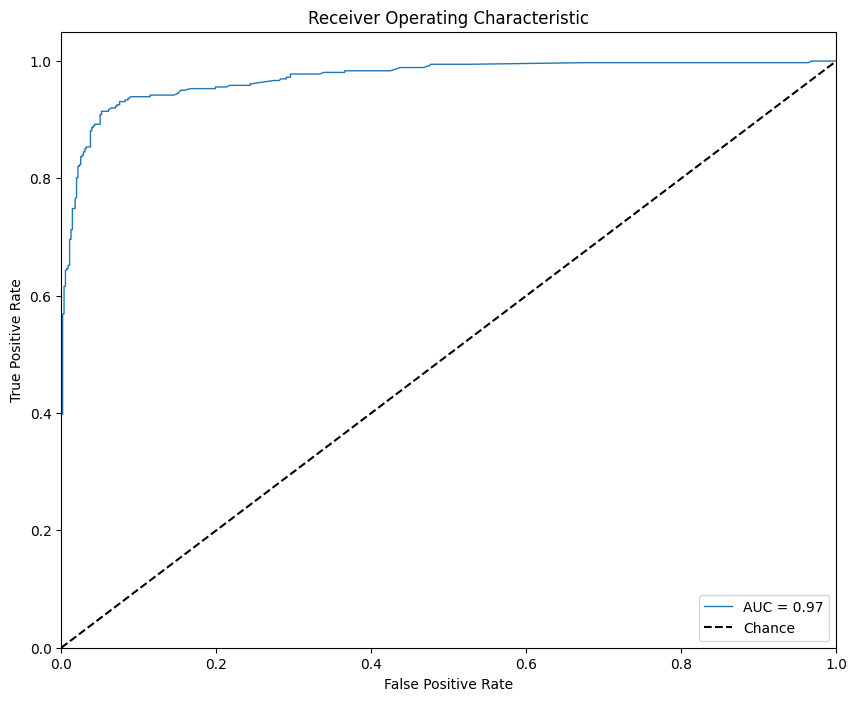

In [20]:
from src.visualization.metrics_visualizer import MetricsVisualizer
metrics_visualizer = MetricsVisualizer(metrics_obj)
metrics_visualizer.plot_roc_curve()